In [10]:
import sys
sys.path.append('../')

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import cv2
import matplotlib.pyplot as plt
import os
from glob import glob
import numpy as np
import math
from skimage import measure
from matplotlib import colors
from tqdm import tqdm

from utils.preprocessor import crop_frame, extract_hair
from utils.segmentation import SegmentMelISIC
from utils.utils import create_directory_if_not_exists

segment_wrapper = SegmentMelISIC()

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

#### 1. Experimenting functions

In [11]:
def create_multi_resolution_pyramid(image, depth = 1, sigma = 1.5, scale_factor = 2, debug=False):
    '''This function create a multi-resolution pyramid of images with a given depth as a parameter. \
        It returns a list of images starting from the lowest to highest resultion if \
        the depth > 1. If the depth is 1, it returns the original images. '''
    
    # https://www.researchgate.net/figure/Multi-resolution-pyramid-model-for-image-registration_fig2_350312761
    # P(7), uses gaussian filter: https://www.sciencedirect.com/science/article/pii/S0898122113002538  
    # check the slides of iterative pyramidal lucas-kanade pyramid design (gaussian filtering + downsampling by 2) to get lower scale/res images

    if depth == 0:
        raise ValueError("Depth can't be equal to 0, minimum allowed value is 1 for a single resolution image registration.")
    
    Images_list  = []

    Images_list.append(image)

    if depth == 1:
        return Images_list, scale_factor
    
    for _ in range(1, depth): # ignore the last level of the pyramid (depth+1), it is the original image
        # Apply Gaussian filtering
        # The lists have the original images, thus we index the last element at the beginning
        # when a new image is appended, that new image is used on the next level for filtering and downsampling
        Images_filtered = cv2.GaussianBlur(Images_list[-1], (0, 0), sigma)

        # Apply downsampling by a factor of 2 for the first time on the original image, 
        Images_downsampled = cv2.resize(Images_filtered, None, fx=1/scale_factor, fy=1/scale_factor, interpolation=cv2.INTER_LINEAR)

        # Appending to the list
        Images_list.append(Images_downsampled)

    # The pyramid should start from the smallest image with the lowest resolution to the highest, reverse the lists
    Images_list.reverse()

    if debug:
        # Show the registration results
        plt.figure(figsize=(10, 8))
        
        view_depth_index = 2  # Only for visual debugging, no visual debugging if depth is 1 (1 level), the index must be equal to 0
        
        plt.imshow(Images_list[view_depth_index], cmap='gray')
        plt.title(f'Image {Images_list[view_depth_index].shape}')

    # Return a pyramid of images , and the scale factor that we will use to scale the optimized parameters when moving between scales
    return Images_list, scale_factor

In [12]:
def plot_image_from_path(file_path):
    # Read the image using OpenCV
    image = cv2.imread(file_path)

    # Convert BGR image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image using Matplotlib
    plt.imshow(image_rgb)
    plt.title(f'{file_path.split("/")[-1]} {image.shape}')
    plt.axis('off')  # Turn off axis labels
    plt.show()

def plot_image(image, title):
    # Convert BGR image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image using Matplotlib
    plt.imshow(image_rgb)
    # plt.title(f'{title}')
    plt.axis('off')  # Turn off axis labels
    plt.show()
    
def plot_image_gray(image, title):
    # Plot the image using Matplotlib
    plt.imshow(image, cmap='gray')
    # plt.title(f'{title} {image.shape}')
    plt.axis('off')  # Turn off axis labels
    plt.show()

def plot_images_in_grid(images_list, rows, cols):
    total_images = len(images_list)
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

    # Ensure axes is a 2D array
    if rows == 1 and cols == 1:
        axes = [[axes]]
    elif rows == 1 or cols == 1:
        axes = [axes]

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index < total_images:
                # Convert BGR image to RGB
                image_rgb = cv2.cvtColor(images_list[index], cv2.COLOR_BGR2RGB)

                # Plot the image
                axes[i][j].imshow(image_rgb)
                axes[i][j].set_title(f'{images_list[index].shape}')
                axes[i][j].axis('off')

    # Adjust layout to prevent clipping
    plt.tight_layout()
    plt.show()


In [4]:
os.listdir('../datasets/challenge1/train/nevus')[0]

'nev00001.jpg'

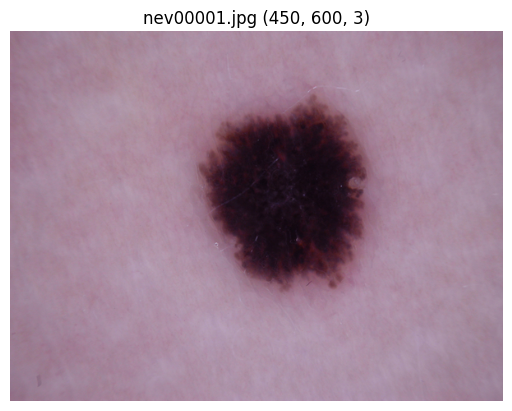

In [5]:
test_image = '../datasets/challenge1/train/nevus/nev00001.jpg'

plot_image_from_path(test_image)

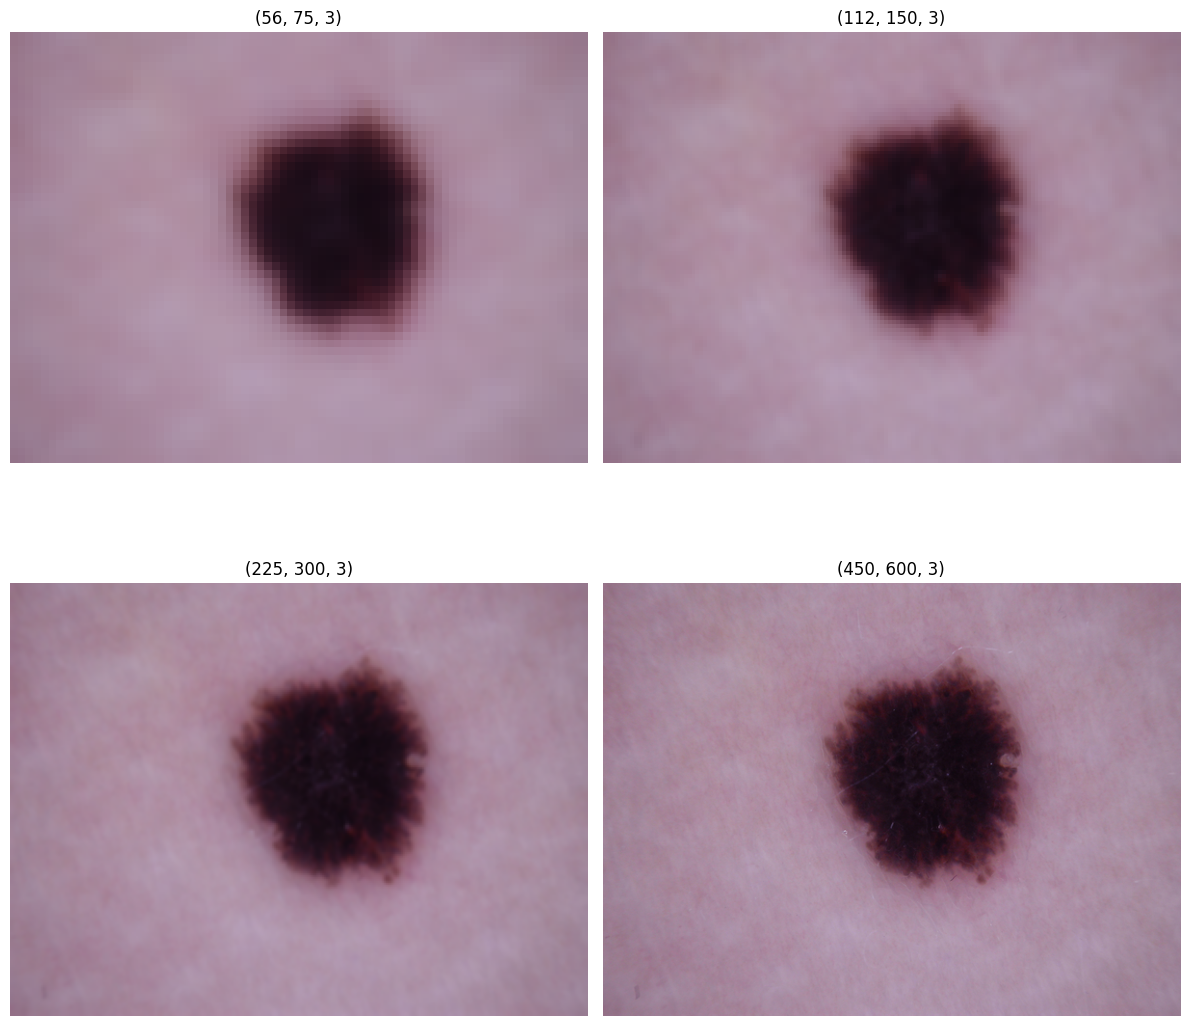

In [6]:
depth = 4

Images_list, scale_factor = create_multi_resolution_pyramid(image = cv2.imread(test_image), depth=depth)

# Plot images in the calculated grid size
plot_images_in_grid(Images_list, 2,2)

In [13]:
def preprocess_image(image):
    # Apply Gaussian blur to smooth the image
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Convert the image to LAB color space
    lab = cv2.cvtColor(blurred, cv2.COLOR_BGR2LAB)
    
    # Split the LAB image into L, A, and B channels
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    # Merge the CLAHE-enhanced L channel with the original A and B channels
    limg = cv2.merge((cl, a, b))
    
    # Convert the LAB image back to BGR color space
    result = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    return result


def segment_lesion(image):
    # Apply adaptive thresholding to segment the image
    _, thresh = cv2.threshold(image.copy().astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Invert the thresholded image
    thresh = cv2.bitwise_not(thresh)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours based on area to remove small noise
    min_contour_area = 100
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
    
    # Create an empty mask to draw the contours
    mask = np.zeros_like(thresh)
    
    # Draw the contours on the mask with a white color
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)
    
    return mask, contours

def postprocess_segmentation(segmentation_mask):
    # Remove small connected components
    labeled_mask = measure.label(segmentation_mask, connectivity=2)
    for region in measure.regionprops(labeled_mask):
        if region.area < 100:
            segmentation_mask[labeled_mask == region.label] = 0
    
    return segmentation_mask

def visualize_results(original_image, segmentation_mask, contours):
    
    # Draw the contours on the original image
    cv2.drawContours(original_image, contours, -1, (0, 0, 255), thickness=2)
    
    # Display the results using Matplotlib
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image with Contours')
    
    axes[1].imshow(cv2.cvtColor(segmentation_mask, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Segmentation Mask')
    
    for ax in axes:
        ax.axis('off')
    
    plt.show()


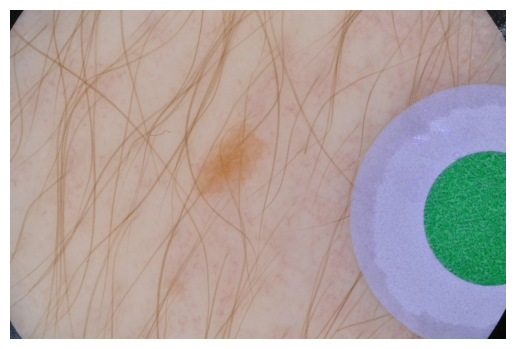

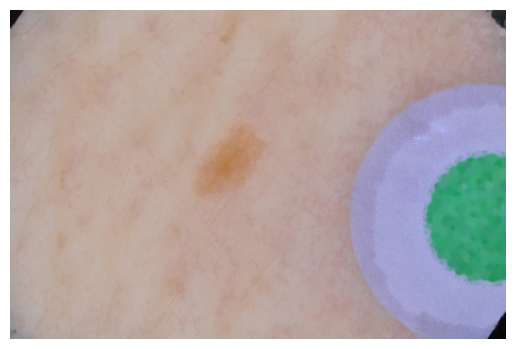

In [14]:
# Example usage
# crop frame cropping - nev00002
# already cropped nev00011
# failing scenario nev00069
# working - nev00001

# nev00354
# nev00451
# fails - nev00486
# nev00558
# nev00693

# image with a marker - nev00603
# failing - nev01171
# 2 markers here - nev01334
# 1 marker - nev01545

# hair perfectly removed nev01827

# nev01827, nev04116

image_path = '../datasets/challenge1/train/nevus/nev01545.jpg'
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
plot_image(image, 'Raw')

image = crop_frame(image)[0]
image = extract_hair(image)

plot_image(image, 'hair extracted and frame cropped')

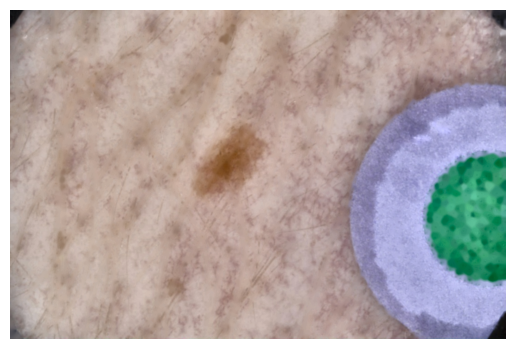

In [15]:
preprocessed_image = preprocess_image(image)

plot_image(preprocessed_image, 'gaussian filtered (preprocessed), GRAY')

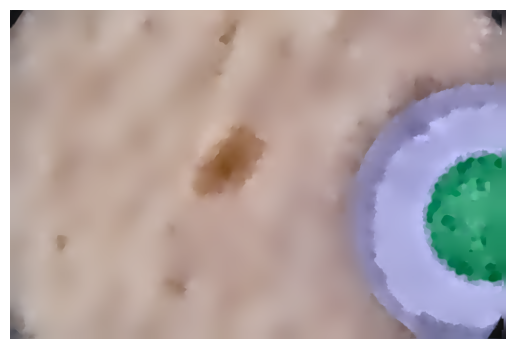

In [16]:
# Apply mean shift filter using OpenCV
filtered_image_uint8 = cv2.pyrMeanShiftFiltering(preprocessed_image, 5, 30, maxLevel=4) # 25, 20)

plot_image(filtered_image_uint8, 'filtered_image_uint8')

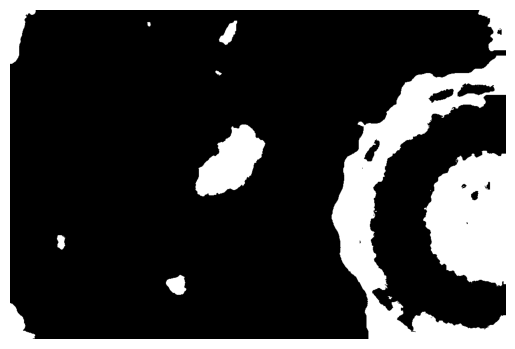

In [17]:
def kmeans(input_img, k=2):
    try:
        # Reshape the image to a 2D array of pixels (rows) and color channels (columns)
        data = input_img.reshape((-1, 3)).astype(np.float32)

        # Perform k-means clustering
        _, labels, centers = cv2.kmeans(
            data, k, None,
            criteria=(cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 10, 1.0),
            attempts=15,
            flags=cv2.KMEANS_PP_CENTERS
        )

        # Replace pixel values with their center value for each channel
        # for i in range(data.shape[0]):
        #     center_id = labels[i]
        #     data[i] = centers[center_id]

        # Reshape the data back to the original image shape
        segmented_img = data.reshape(input_img.shape).astype(np.uint8)

        # Convert the segmented image to grayscale
        segmented_gray = cv2.cvtColor(segmented_img, cv2.COLOR_BGR2GRAY)

        # Apply adaptive thresholding to obtain a binary image
        _, thresholded_img = cv2.threshold(segmented_gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)

        return thresholded_img

    except Exception as e:
        print(str(e))

# Assuming filtered_image_uint8 is your input color image
kmeans_result = kmeans(filtered_image_uint8, k=2)

plot_image_gray(kmeans_result, 'kmeans_result')

(881, 387) 324 (680, 1024)


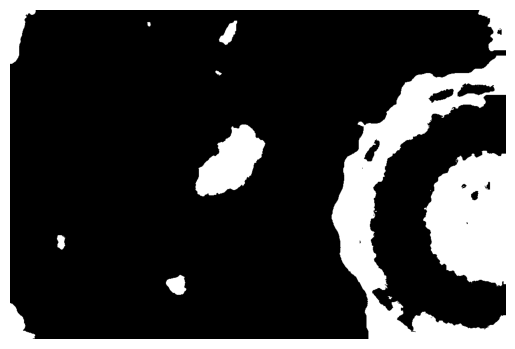

In [18]:
def remove_circular_borders(image):
    # Find connected components and their properties
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the center and diameter of the largest component
    largest_contour = max(contours, key=cv2.contourArea)

    # finds a circle of the minimum area enclosing an area
    (x , y), radius = cv2.minEnclosingCircle(largest_contour) # returns the center and radius

    center = (int(x), int(y)) #(x, y)
    radius = int(radius)

    print(center, radius, image.shape)

    if radius < max(image.shape)//2:
        return image

    # Calculate border size based on a percentage of the circle radius
    border_percentage = (radius / min(image.shape[0], image.shape[1])) * 100
    if border_percentage > 25:
        border_percentage = 25
        
    border_size = int(radius * border_percentage / 100)

    print(border_percentage, border_size)

    # Calculate border size based on a percentage of the image size
    # border_size = int(min(image.shape[0], image.shape[1]) * border_percentage / 100)

    # Create a new white image with the same shape as the original image
    result_image = np.zeros_like(image)

    # Crop the image to focus on the center
    y_min = border_size
    y_max = image.shape[0] - border_size
    x_min = border_size
    x_max = image.shape[1] - border_size

    # Copy the cropped tumor region into the new image
    result_image[y_min:y_max, x_min:x_max] = image[y_min:y_max, x_min:x_max]

    return result_image

segmentation = remove_circular_borders(kmeans_result)

plot_image_gray(segmentation, 'segmentation')

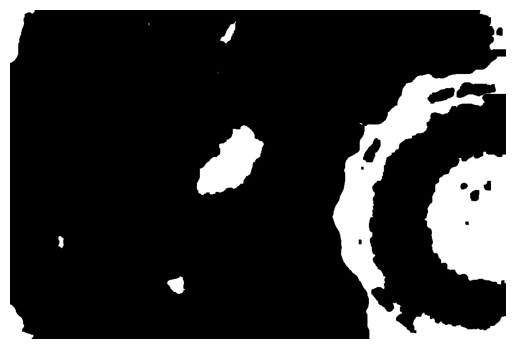

In [19]:
def remove_lines(image, kernel_size = (5, 5), iterations=2):
    # Apply erosion to remove lines (adjust the kernel size as needed)
    return cv2.erode(image, kernel=np.ones(kernel_size, np.uint8), iterations=iterations)

eroded_image = remove_lines(segmentation, iterations=1)

plot_image_gray(eroded_image, 'eroded_image')

[  0 255]


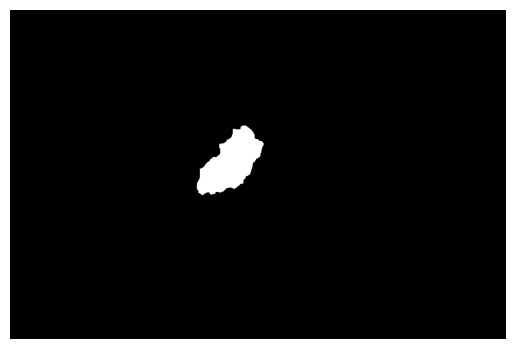

In [61]:
def keep_largest_region_center(segmentation):
    # Find contours in the binary mask
    contours, _ = cv2.findContours(segmentation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return segmentation

    # Find the contour with the largest area
    # largest_contour = max(contours, key=cv2.contourArea)

    # Find the center of the image
    center_x, center_y = segmentation.shape[1] // 2, segmentation.shape[0] // 2 # //3

    # Filter contours based on their proximity to the center
    distance_to_center = lambda c: np.linalg.norm(np.mean(c, axis=0) - np.array([center_x, center_y]))
    contours_centered = sorted(contours, key=distance_to_center)

    # Select the contour closest to the center (largest in the center)
    largest_contour_centered = contours_centered[0]

    # Create an empty mask to draw the largest contour
    result_mask = np.zeros_like(segmentation)

    # Draw the largest contour on the empty mask
    cv2.drawContours(result_mask, [largest_contour_centered], 0, 255, thickness=cv2.FILLED)

    return result_mask


seg_lesion = keep_largest_region_center(eroded_image)

print(np.unique(seg_lesion))

plot_image_gray(seg_lesion, 'seg_lesion')

In [62]:
# def keep_largest_region(segmentation):
#     # Find contours in the binary mask
#     contours, _ = cv2.findContours(segmentation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     if not contours:
#         return segmentation

#     # Find the contour with the largest area
#     largest_contour = max(contours, key=cv2.contourArea)

#     # Create an empty mask to draw the largest contour
#     result_mask = np.zeros_like(segmentation)

#     # Draw the largest contour on the empty mask
#     cv2.drawContours(result_mask, [largest_contour], 0, 255, thickness=cv2.FILLED)

#     return result_mask


In [63]:
np.unique(seg_lesion)

array([  0, 255], dtype=uint8)

In [64]:
print(seg_lesion.shape)

(680, 1024)


In [65]:
import torch.nn.functional as F
from torchvision import transforms


transform = transforms.Compose([
    transforms.ToTensor(),
])

In [66]:
seg_lesion_tensor = transform(seg_lesion)
print(seg_lesion_tensor.shape)

torch.Size([1, 680, 1024])


In [67]:
# seg_lesion_tensor = seg_lesion_tensor.unsqueeze(0)
# print(seg_lesion_tensor.shape)

In [167]:
seg_1 = F.adaptive_avg_pool2d(seg_lesion_tensor, 225//8)
print(seg_1.shape)

torch.Size([1, 28, 28])


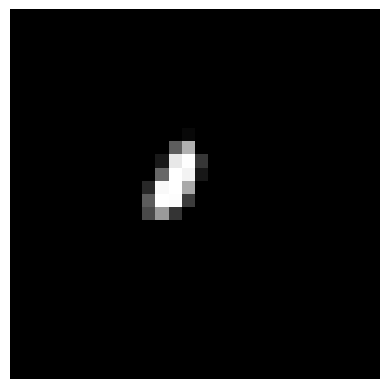

In [168]:
seg_1_np = seg_1.squeeze().numpy()
plot_image_gray(seg_1_np, 'seg_1_np')


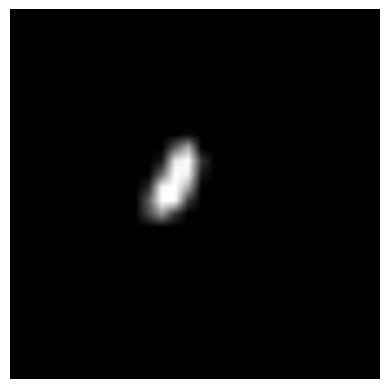

In [169]:
seg_1 = seg_1.unsqueeze(0)
a = F.interpolate(seg_1, scale_factor=8, mode='bilinear', align_corners=False)

a_1_np = a.squeeze().numpy()
plot_image_gray(a_1_np, 'seg_1_np')

In [170]:
np.unique(a_1_np)

array([0.0000000e+00, 1.2668919e-04, 3.5472971e-04, ..., 9.9628383e-01,
       9.9694192e-01, 9.9798965e-01], dtype=float32)

In [171]:
a.shape

torch.Size([1, 1, 224, 224])

In [172]:
a.max()

tensor(0.9980)

In [173]:
attn = a.mul(255).byte().cpu().numpy()

In [174]:
attn.max()

254

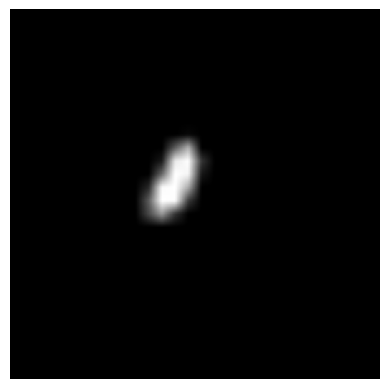

In [175]:
attn = attn.squeeze()
plot_image_gray(attn, 'attn_np')

In [176]:
np.unique(attn)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [177]:
# attn_color = cv2.cvtColor(attn, cv2.COLOR_GRAY2BGR).astype(np.uint8)
# print(attn_color.shape)

In [178]:
attn = cv2.applyColorMap(attn.astype(np.uint8), cv2.COLORMAP_JET)
print(attn.shape)

(224, 224, 3)


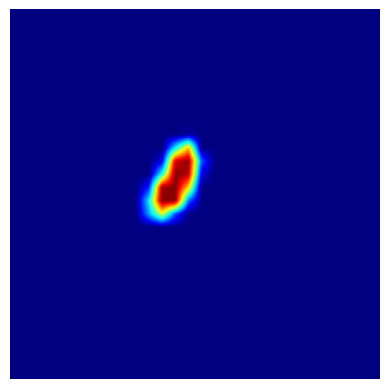

In [179]:
plot_image(attn, 'attn')

In [180]:
attn.shape[:2]

(224, 224)

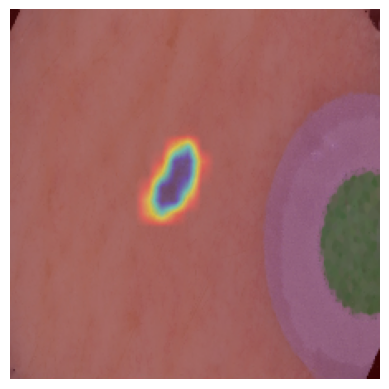

In [181]:
attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
# attn = np.float32(attn) / 255
vis = 0.6 * cv2.resize(image, attn.shape[:2], interpolation=cv2.INTER_CUBIC) + 0.4 * attn
vis = np.uint8(vis)

plot_image(vis, 'attn')

#### 2. Testing Segmentation Class

(1024, 1024) [  0 255] uint8


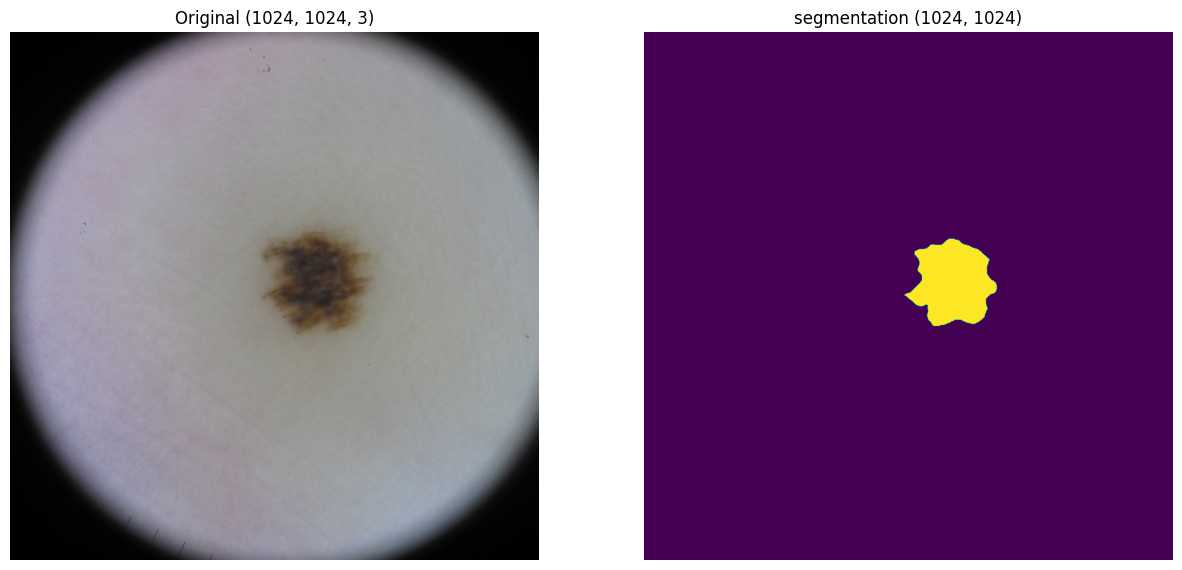

In [352]:
# image_path = '../datasets/challenge1/train/nevus/nev04706.jpg'
image_path = '../datasets/challenge1/test/testX/xxx00001.jpg'
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

cropped_image = crop_frame(image)[0]
cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

segmentation = segment_wrapper.predict(image_path)
print(segmentation.shape, np.unique(segmentation), segmentation.dtype)

plt.figure(figsize=(15, 9))
plt.subplot(1,2,1)
plt.imshow(cropped_image)
plt.title(f'Original {cropped_image.shape}')
plt.axis('off')  # Turn off axis labels

plt.subplot(1,2,2)
plt.imshow(segmentation[:, :, np.newaxis])
plt.title(f'segmentation {segmentation.shape}')
plt.axis('off')  # Turn off axis labels
plt.show()

In [342]:
# # exporting
# seg_path = './test_seg.jpg'

# cv2.imwrite(seg_path, segmentation)

True

(682, 1024) uint8 [  0 255]


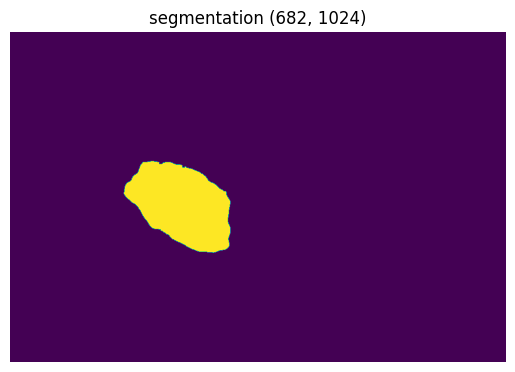

In [346]:
# seg_test = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)
# # Threshold the image to convert it into a binary format
# _, binary_image = cv2.threshold(seg_test, 128, 255, cv2.THRESH_BINARY)

# print(binary_image.shape, binary_image.dtype, np.unique(binary_image))

# plt.imshow(binary_image[:, :, np.newaxis])
# plt.title(f'segmentation {segmentation.shape}')
# plt.axis('off')  # Turn off axis labels
# plt.show()

In [289]:
# good for demo 
# pen markers similar to the lesion: nev03975
# with hair nev01827, nev04116
# skin with water xxx01167

#### 3. Segmenting all dataset

In [308]:
os.listdir('../datasets/')

['.gitkeep', 'challenge1', 'challenge2', 'melanoma_hairs']

In [ ]:
base_path = '../datasets/'
challenges = ['challenge1', 'challenge2']

for challenge in challenges:
    challenge_dir = os.path.join(base_path, challenge)
    
    for split in os.listdir(challenge_dir):
        split_path = os.path.join(challenge_dir, split)
        
        for split_folder in os.listdir(split_path):
            original_path = os.path.join(split_path, split_folder)
            new_path = original_path.replace('datasets', 'datasets_masks')

            create_directory_if_not_exists(new_path)
            
            print(f"Segmenting images in {original_path} ...")
            for image in tqdm(os.listdir(original_path)):
                img_path = os.path.join(original_path, image)
                mask_path = os.path.join(new_path, image)

                segmentation = segment_wrapper.predict(img_path)
                cv2.imwrite(mask_path, segmentation)


Segmenting images in ../datasets/challenge1/test/testX ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6340/6340 [24:44:35<00:00, 14.05s/it]


Segmenting images in ../datasets/challenge1/train/nevus ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7725/7725 [24:17:34<00:00, 11.32s/it]


Segmenting images in ../datasets/challenge1/train/others ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7470/7470 [34:17:30<00:00, 16.53s/it]


Segmenting images in ../datasets/challenge1/val/nevus ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1931/1931 [6:20:45<00:00, 11.83s/it]


Segmenting images in ../datasets/challenge1/val/others ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1865/1865 [7:55:24<00:00, 15.29s/it]


Segmenting images in ../datasets/challenge2/test/testX ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2121/2121 [10:43:33<00:00, 18.21s/it]


Segmenting images in ../datasets/challenge2/train/bcc ...


 59%|█████████████████████████████████████████████████████████████████████████████▉                                                       | 1167/1993 [13:25:59<3:59:27, 17.39s/it]

Continue segmenting challenge 2

In [ ]:
base_path = '../datasets/'
challenges = ['challenge2']

for challenge in challenges:
    challenge_dir = os.path.join(base_path, challenge)

    # os.listdir(challenge_dir)
    for split in [dir for dir in os.listdir(challenge_dir) if dir != 'test']:
        split_path = os.path.join(challenge_dir, split)
        
        for split_folder in os.listdir(split_path):
            original_path = os.path.join(split_path, split_folder)
            new_path = original_path.replace('datasets', 'datasets_masks')

            print(original_path, new_path)

            create_directory_if_not_exists(new_path)
            
            print(f"Segmenting images in {original_path} ...")
            for image in tqdm(os.listdir(original_path)):
                img_path = os.path.join(original_path, image)
                mask_path = os.path.join(new_path, image)

                segmentation = segment_wrapper.predict(img_path)
                cv2.imwrite(mask_path, segmentation)


../datasets/challenge2/train/mel ../datasets_masks/challenge2/train/mel
Segmenting images in ../datasets/challenge2/train/mel ...


  0%|                                    | 4/2713 [00:09<1:48:06,  2.39s/it]